In [1]:
!pip install -q transformers datasets segments-ai evaluate

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
import torch
from matplotlib import pyplot as plt
import numpy as np

In [4]:
hf_username = "masoudT"

In [5]:
hf_dataset_identifier = "scene_parse_150"

In [6]:
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:10]")

In [7]:
ds = ds.shuffle(seed=1)
ds = ds.train_test_split(test_size=0.2, shuffle=False)
train_ds = ds["train"]
test_ds = ds["test"]

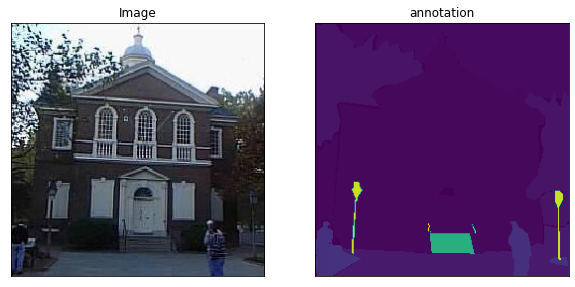

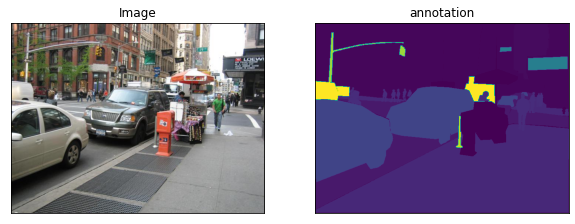

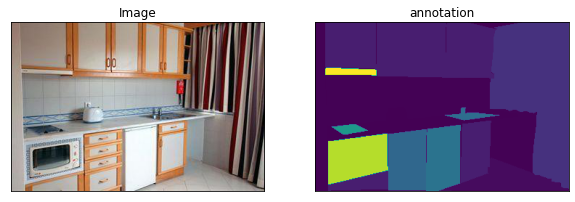

In [10]:
import numpy as np
import matplotlib.pyplot as plt

imgs = []

for i in range(3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    axs[0].imshow(train_ds[i]['image'])
    imgs.append(train_ds[i]['image'])
    axs[0].set_title('Image')
    axs[0].set_xticks([]), axs[0].set_yticks([])
    axs[1].imshow(train_ds[i]['annotation'])
    axs[1].set_title('annotation')
    axs[1].set_xticks([]), axs[1].set_yticks([])

In [11]:
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation

model_name = "microsoft/beit-base-finetuned-ade-640-640"
feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, do_center_crop=False)
model = BeitForSemanticSegmentation.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BeitForSemanticSegmentation(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (in

In [12]:
def transform(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs

train_ds.set_transform(transform)
test_ds.set_transform(transform)

In [12]:
! pip install transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for transforms: filename=transforms-0.1-py3-none-any.whl size=39350 sha256=a95e53e59669abf0ea5bc8fd6487abd4e5fb046e903968a304720de46d6cc568
  Stored in directory: /root/.cache/pip/wheels/3c/82/39/103cb44ae404f3a91336aa44d803b7243300ac720e9e9b82f8
Successfully built transforms


In [13]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [14]:
from transformers import BeitForSemanticSegmentation

pretrained_model_name = "microsoft/beit-base-finetuned-ade-640-640"

model = BeitForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label, 
    label2id=label2id,
    ignore_mismatched_sizes=True
)

In [15]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00005
batch_size = 2

hub_model_id = "Beit"

training_args = TrainingArguments(
    "./BeitOutputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

In [16]:
from transformers import Trainer

train_ds = train_ds.rename_columns({'image': 'pixel_values', 'scene_category': 'labels', 'annotation':'label'})
test_ds = test_ds.rename_columns({'image': 'pixel_values', 'scene_category': 'labels', 'annotation':'label'})

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

/content/./BeitOutputs is already a clone of https://huggingface.co/masoudT/Beit. Make sure you pull the latest changes with `repo.git_pull()`.


In [19]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8
  Num Epochs = 50
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 200
  Number of trainable parameters = 163407980


RuntimeError: ignored

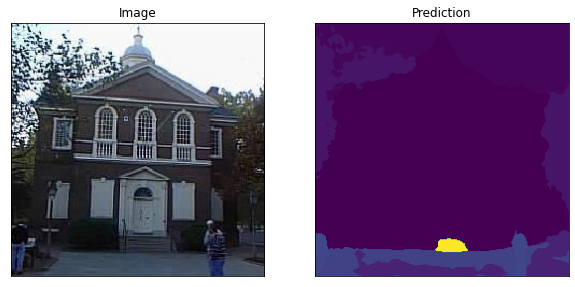

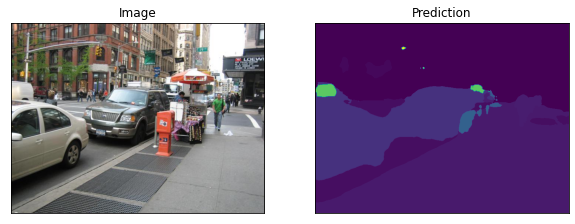

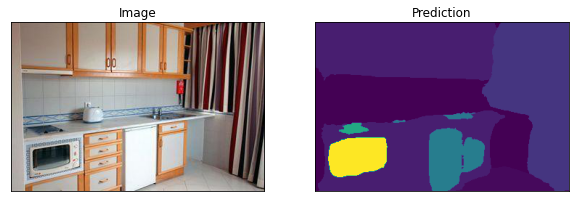

In [19]:
for img in imgs:
    encoding = feature_extractor(img, return_tensors="pt")
    pixel_values = encoding.pixel_values

    outputs = model(pixel_values=pixel_values.cuda())
    logits = outputs.logits

    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=img.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]

    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    axs[0].imshow(img)
    axs[0].set_title('Image')
    axs[0].set_xticks([]), axs[0].set_yticks([])
    axs[1].imshow(pred_seg.cpu())
    axs[1].set_title('Prediction')
    axs[1].set_xticks([]), axs[1].set_yticks([])